In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
# --- Standard library ---
import os
import sys
import time

import psutil

# --- Scientific / data ---
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigsh
from scipy.stats import expon, invgauss, linregress

# --- Plotting ---
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5


# --- Local modules ---
import pcms.haar
import pcms.stats
import pcms.tree
import utils

In [68]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
BS_DATA = os.path.join(DATA, 'human_body_sites')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Verify functionality of CDF estimator

### Difference of Dirichlets CDF

#### Evaluate at a single point

In [66]:
n_leaves = 1000
tree = pcms.tree.cbst(n_leaves=n_leaves)
y = 0.04
eps = 0.01
delta = 0.01

In [67]:
node = np.random.choice(tree.find_interior_nodes())

In [68]:
cdf_val_dod = pcms.stats.cdf_coord_dod(y, tree, node=node)

In [69]:
print(cdf_val_dod)

1.0


#### Evaluate at multiple points

In [70]:
n_points = 1000
ys_dod = np.linspace(-0.01, 0.01, n_points)

In [71]:
cdf_vals_dod = pcms.stats.cdf_coord_dod(ys_dod, tree, node=node)

In [72]:
quantile_levels = [0.5, 0.8, 0.9, 0.95]
quantiles_dod = np.interp(quantile_levels, cdf_vals_dod, ys_dod)
quant50_dod, quant80_dod, quant90_dod, quant95_dod = quantiles_dod

In [73]:
print(quant50_dod, quant80_dod, quant90_dod, quant95_dod)

1.0473249909869843e-06 0.000739342791066928 0.0012029416997297077 0.0016390475581964927


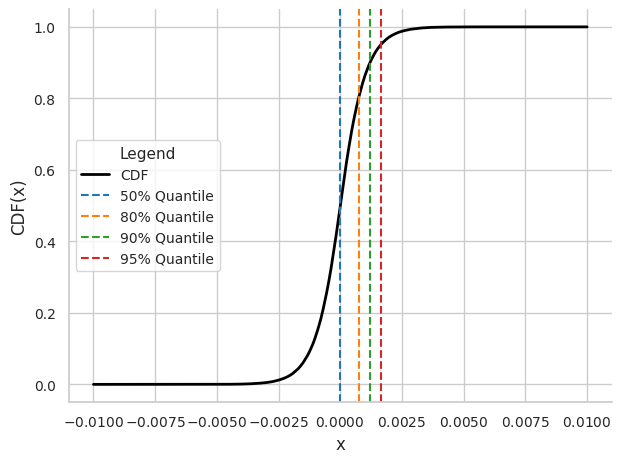

In [74]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

ax.plot(ys_dod, cdf_vals_dod, label='CDF', color='black', linewidth=2)

ax.axvline(quant50_dod, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_dod, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_dod, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_dod, linestyle='--', color='#d62728', label='95% Quantile')

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

# Scientific notation formatter
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 4))  # Use scientific notation if exponent < -3 or > 4
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

## Part 2: Level of significance of Haar-like coordiantes of Guerrero Negro microbial mat dataset against 97% Greengenes tree

### Load 97% Greengenes tree

In [208]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

In [209]:
interior_nodes = tree.find_interior_nodes()
tax_filepath = os.path.join(GG_DATA, 'taxonomy/97_otu_taxonomy.txt')

In [210]:
edge_lengths = tree.get_edge_length()
min_edge_length = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {min_edge_length}")

for node in range(tree.n_nodes):
    tree.set_edge_length(node, max(min_edge_length, tree.get_edge_length(node)))

Enforced minimum edge lenght: 0.0001


### Load Guerrero Negro dataset

In [211]:
gn_table_filepath = os.path.join(GN_DATA, '454/47908_otu_table.tsv')
gn_table_df = utils.load_seq_id_abundances_from_biom_tsv(gn_table_filepath)

In [212]:
# Convert counts to proportions
cols = gn_table_df.columns[1:]
gn_table_df[cols] = gn_table_df[cols].div(gn_table_df[cols].sum(axis=0), axis=1)

# Append leaf index column
leaf_idxs = seq_id2leaf_idx[gn_table_df['OTU ID']].values
gn_table_df.loc[:, 'Leaf Index'] = leaf_idxs
gn_table_df.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [213]:
print(gn_table_df)

       OTU ID  1200.GN01P  1200.GN01P.o  1200.GN02P  1200.GN02P.o  1200.GN03P  \
0     2773512    0.000000           0.0    0.000000      0.000602    0.000000   
1     4361967    0.000000           0.0    0.000000      0.000602    0.000000   
2     3675511    0.001170           0.0    0.001155      0.000000    0.000696   
3     2877492    0.000000           0.0    0.000578      0.000000    0.001392   
4     4481520    0.000000           0.0    0.000000      0.000000    0.008351   
...       ...         ...           ...         ...           ...         ...   
1700  4331263    0.000000           0.0    0.000000      0.000000    0.000000   
1701   252805    0.000585           0.0    0.001733      0.003008    0.000696   
1702  4453795    0.000000           0.0    0.000000      0.000000    0.001392   
1703  1549742    0.000000           0.0    0.000000      0.000000    0.000000   
1704  1636411    0.000000           0.0    0.000000      0.000000    0.000000   

      1200.GN03P.o  1200.GN

In [214]:
filtered_df = gn_table_df.loc[(gn_table_df['1200.GN01P'] != 0) | (gn_table_df['1200.GN09P'] != 0), ['1200.GN01P', '1200.GN09P']]

In [215]:
filtered_df

,1200.GN01P,1200.GN09P
2,0.001170,0.000000
5,0.001170,0.000000
8,0.000000,0.000978
9,0.000000,0.006843
10,0.000000,0.003910
...,...,...
1695,0.000000,0.001955
1697,0.000000,0.002933
1699,0.000000,0.000978
1701,0.000585,0.000000


### Compute Haar-like coordinates

In [216]:
Q, S = pcms.haar.sparsify(tree)

In [217]:
a_s = gn_table_df['1200.GN09P.o']
b_s = gn_table_df['1200.GN01P.o']

indices = gn_table_df['Leaf Index'].values
n_leaves = tree.find_leaves().size

a_vals = a_s.values
a = np.zeros((n_leaves,))
a[indices] = a_vals

b_vals = b_s.values
b = np.zeros((n_leaves,))
b[indices] = b_vals

diff = a - b

In [218]:
hl_coords = Q.T @ diff
dh_comps = hl_coords**2 * S.diagonal()

In [219]:
S_coo = S.tocoo()
row, col, Svals = S_coo.row, S_coo.col, S_coo.data
hl_coords_i = hl_coords[row]
hl_coords_j = hl_coords[col]
contrib_data = Svals * hl_coords_i * hl_coords_j
M = csc_matrix((contrib_data, (row, col)), shape=S.shape)
M.eliminate_zeros()

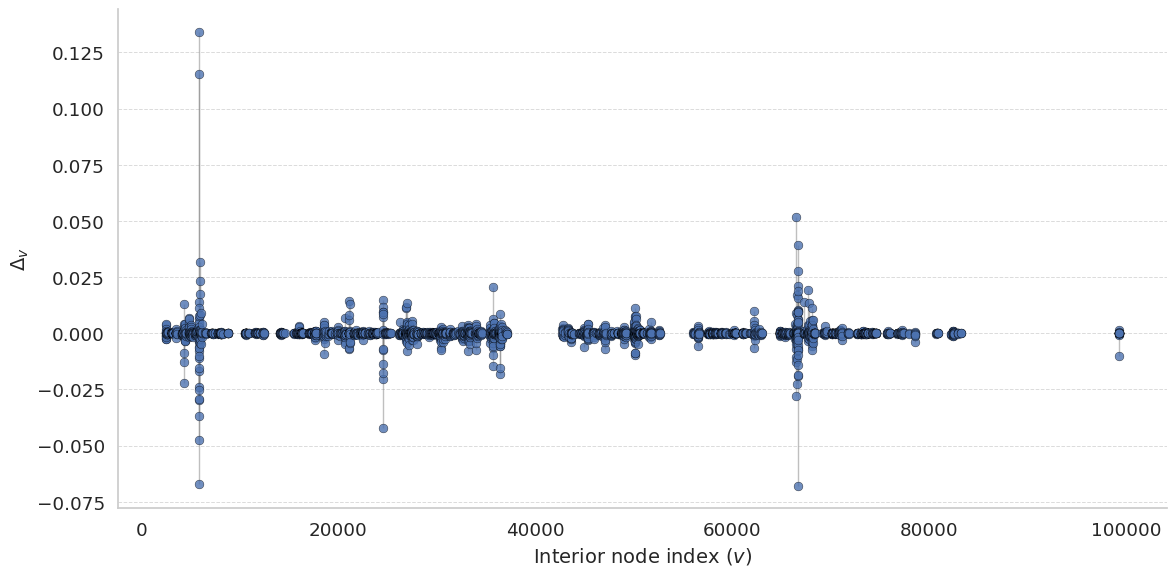

In [220]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(hl_coords)[0]
y = hl_coords[idx]
x = idx

# Scatter points colored by value with better aesthetics
ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Draw vertical lines behind scatter points
ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Improve axes labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

# Add a grid on y-axis only for clarity
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()

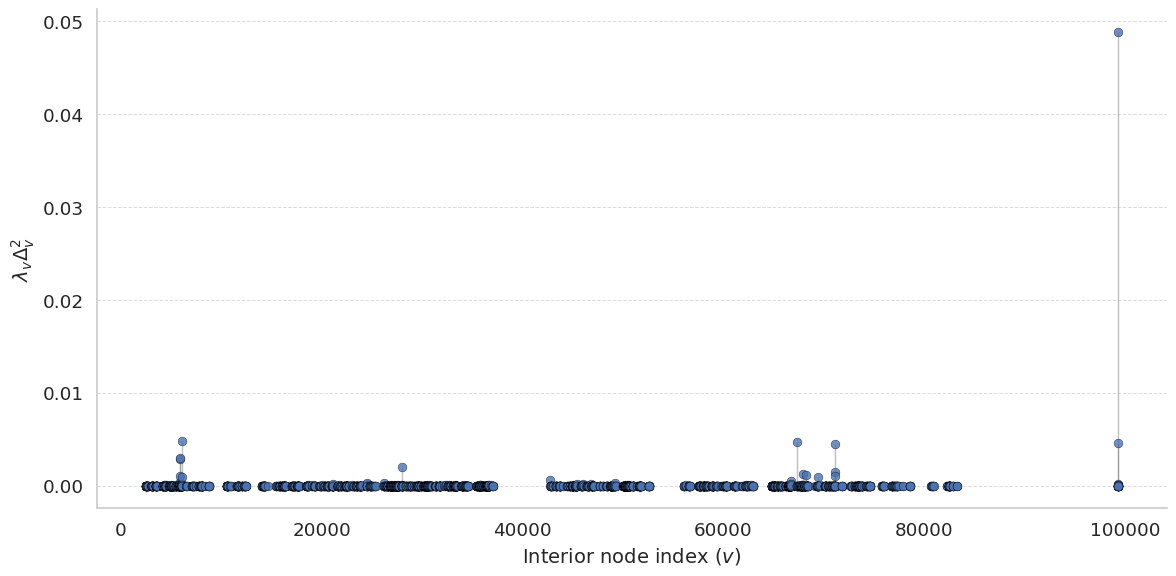

In [221]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(dh_comps)[0]
y = dh_comps[idx]
x = idx

# Scatter points with subtle edge for clarity
ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Vertical lines behind scatter points
ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

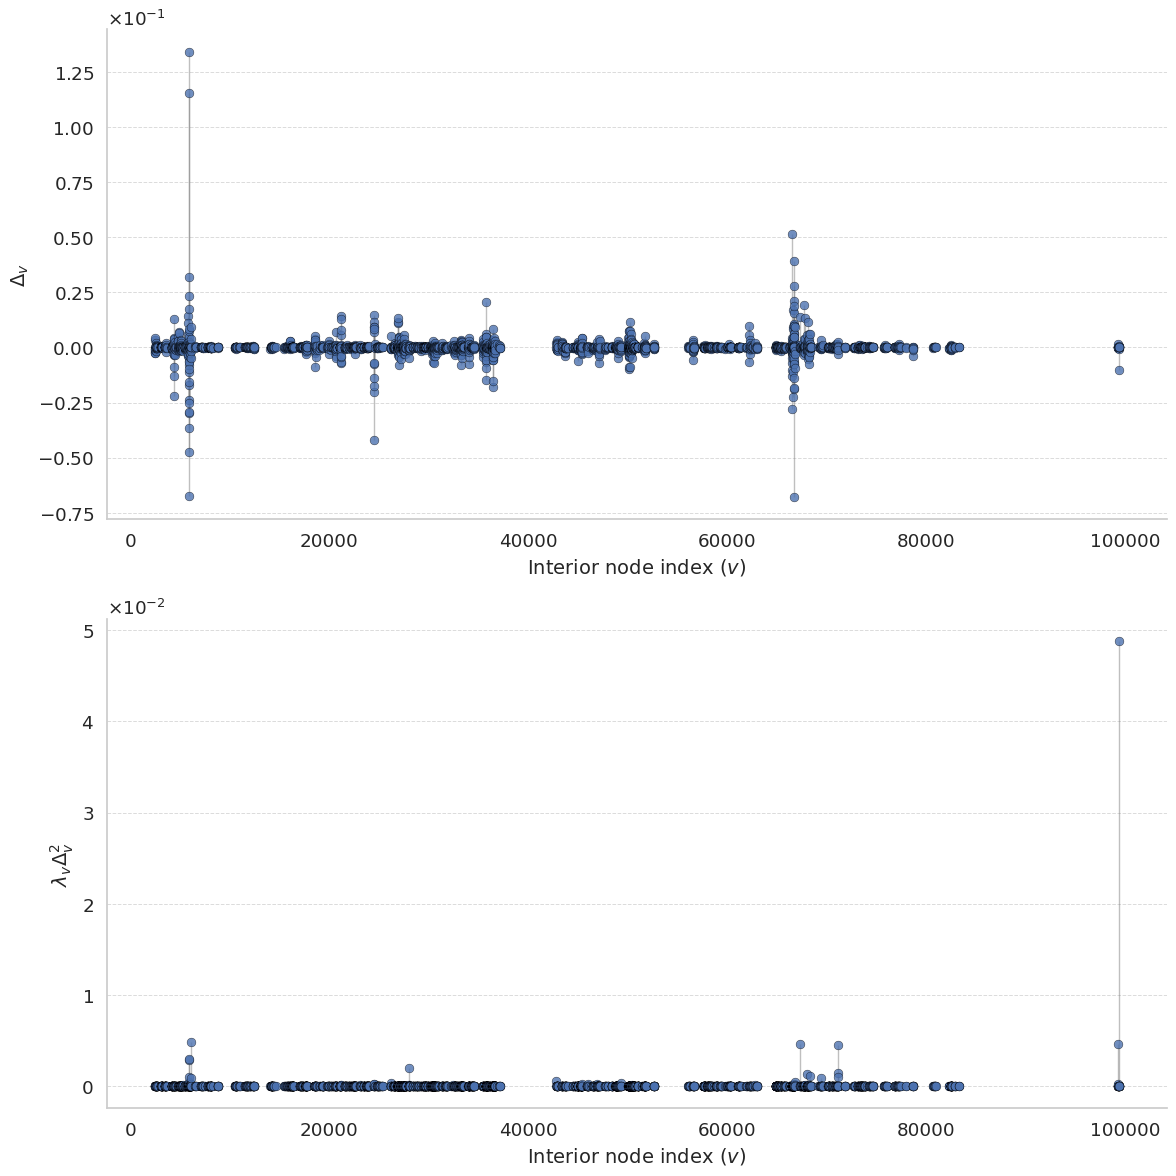

In [222]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharey=False)

# --- Plot 1: coords plot ---
idx = np.where(hl_coords)[0]
y = hl_coords[idx]
x = idx
# Scatter points colored by value with better aesthetics
ax1.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
# Draw vertical lines behind scatter points
ax1.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax1.set_xlabel('Interior node index ($v$)', fontsize=14)
ax1.set_ylabel(r'$\Delta_v$', fontsize=14)
ax1.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax1.xaxis.grid(False)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax1)

# --- Plot 2: dh_coords plot ---
idx = np.where(dh_comps)[0]
y = dh_comps[idx]
x = idx
# Scatter points with subtle edge for clarity
ax2.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
# Vertical lines behind scatter points
ax2.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax2.set_xlabel('Interior node index ($v$)', fontsize=14)
ax2.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax2.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax2.xaxis.grid(False)
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

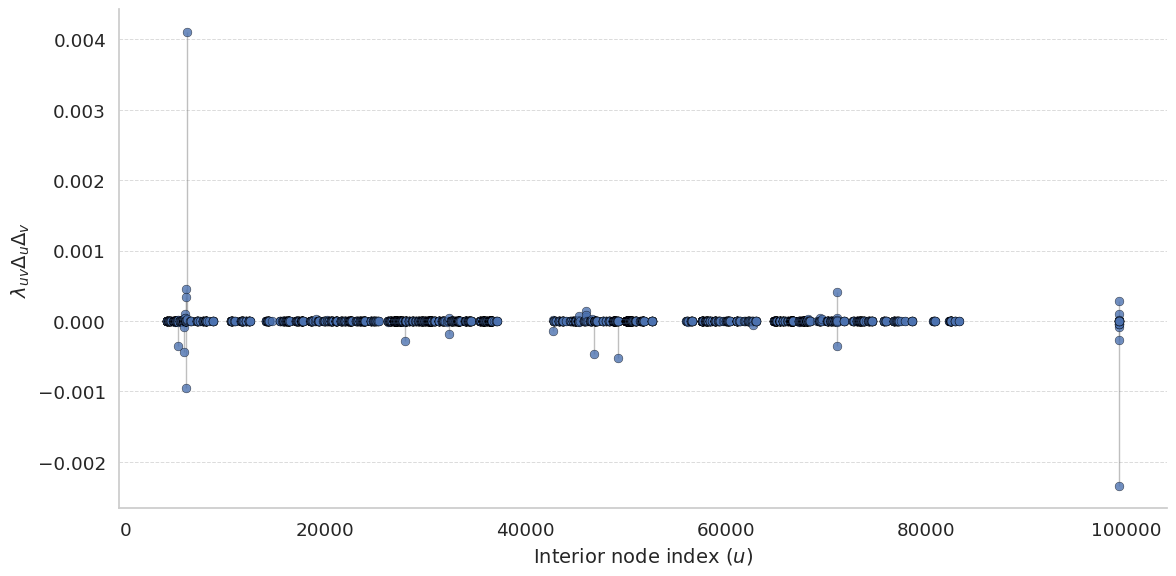

In [223]:
sns.set(style="whitegrid", font_scale=1.2)

v = 99310
col = M[:, v].tocoo()

mask = col.row != v
idx = col.row[mask]
y = col.data[mask]
x = idx

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

ax.set_xlabel('Interior node index ($u$)', fontsize=14)
ax.set_ylabel(r'$\lambda_{uv} \Delta_u \Delta_v$', fontsize=14)

ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

sns.despine()

plt.tight_layout()
plt.show()

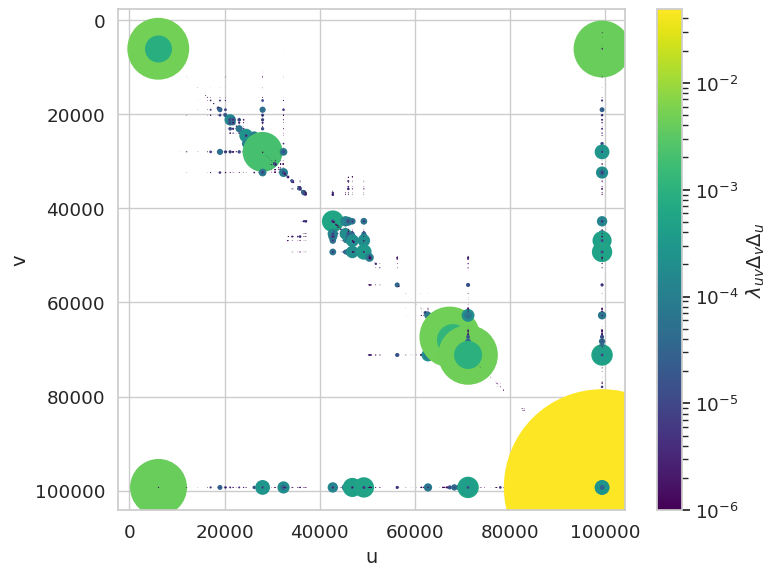

In [224]:
from matplotlib.colors import LogNorm

M_coo = M.tocoo()
rows, cols, vals = M_coo.row, M_coo.col, M_coo.data
vals = np.abs(vals)

scale_factor = 2e4
scale_power = 1
eps = 1e-6

fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(
    cols, rows,
    c=vals,
    cmap="viridis",
    norm=LogNorm(vmin=max(vals.min(), eps), vmax=vals.max()),
    marker="o",
    s=scale_factor * (vals / vals.max()) ** scale_power,
    edgecolors='none'
)

ax.set_xlabel("u", fontsize=14)
ax.set_ylabel("v", fontsize=14)
ax.invert_yaxis()

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"$\lambda_{uv}\Delta_v\Delta_u$", fontsize=14)

plt.tight_layout()
plt.show()

In [225]:
np.abs(np.sum(dh_comps) - np.sum(M.data)) / np.abs(np.sum(M.data))

np.float64(0.009765109328402823)

In [226]:
N = M.shape[0]
dh_comps_alt = M.diagonal().copy()

# M.data and M.indices correspond to columns
for j in range(N):
    start, end = M.indptr[j], M.indptr[j+1]
    rows = M.indices[start:end]
    data = M.data[start:end]
    
    # Only consider entries above the diagonal (i < j)
    mask = rows > j
    dh_comps_alt[rows[mask]] -= 2 * data[mask]

sort_idx_alt = np.argsort(dh_comps_alt)[::-1]

### Difference of Dirichlet CDF

In [76]:
intr_nodes = tree.find_interior_nodes()
subtree_starts = tree.find_subtree_start_indices()
subtree_sizes = tree.get_subtree_size()

In [35]:
start = time.time()

mask = np.where(hl_coords > 0.0)[0]

pvals_dod = np.zeros(mask.size)
for m_idx, idx in enumerate(mask):
    node_idx = intr_nodes[idx]
    children = tree.find_children(node_idx)
    if children.size == 1:
        pvals_dod[m_idx] = 1.0
    else:
        cdf_val = pcms.stats.cdf_coord_dod(
            hl_coords[idx], 
            tree=tree,
            node=node_idx,
            eps=0.005,
            delta=0.001
        )
        pvals_dod[m_idx] = 2 * min(cdf_val, 1 - cdf_val)

print("Elapsed time: ", time.time() - start)

Elapsed time:  59.26917004585266


In [36]:
alpha = 0.05
do_reject_dod = pvals_dod < alpha

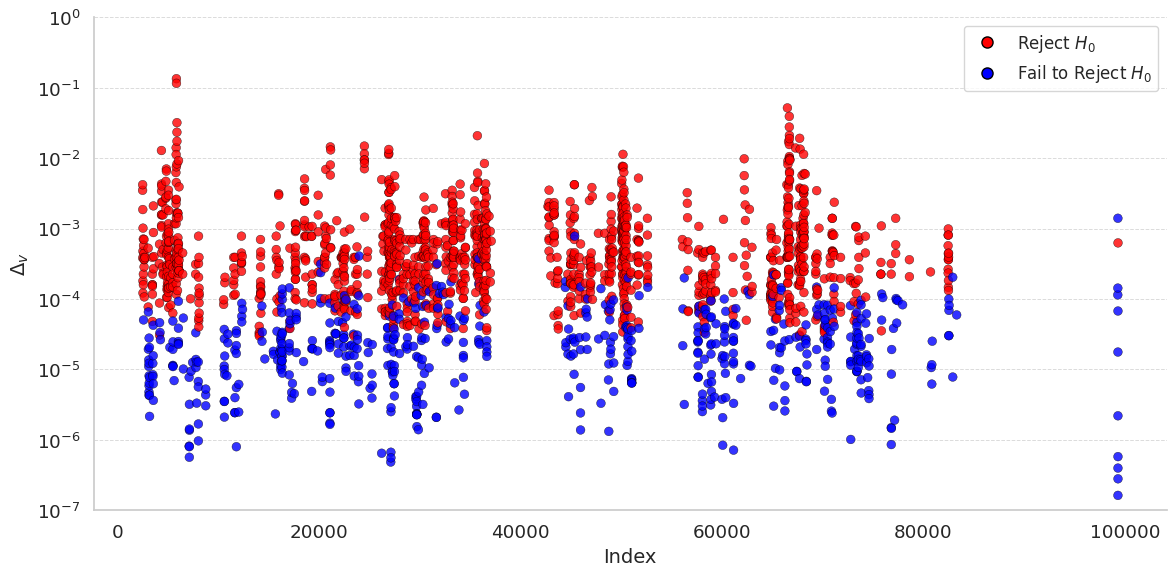

In [77]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to colors: True → red, False → blue
colors = np.where(do_reject_dod, 'red', 'blue')

y = hl_coords[mask]
x = mask

# Scatter with edge and higher zorder
scatter = ax.scatter(
    x, y,
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Use log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-7, 1])

# Custom legend with clearer labels and markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Axis labels
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel(r'$\Delta_{v}$', fontsize=14)

# Add y-axis grid only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove clutter
sns.despine()

plt.tight_layout()
plt.show()

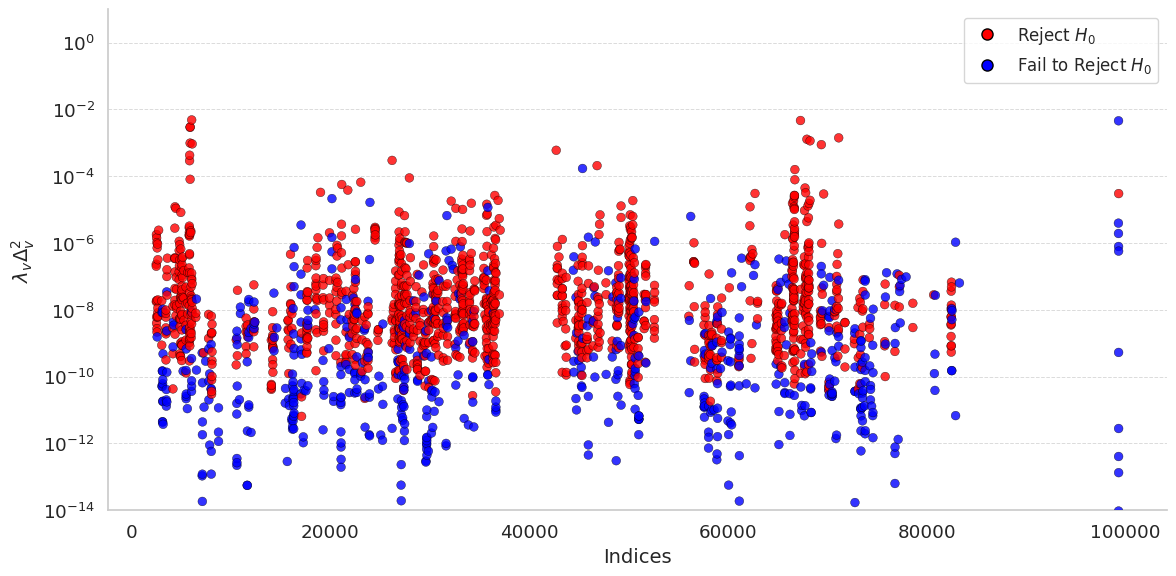

In [78]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to binary colors: True → red, False → blue
colors = np.where(do_reject_dod, 'red', 'blue')

y = dh_comps[mask]
x = mask

# Scatter plot with edge color for clarity
scatter = ax.scatter(
    x, y,
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-14, 1e1])

# Custom legend with edge color to match scatter
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Labels
ax.set_xlabel('Indices', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Clean up plot spines
sns.despine()

plt.tight_layout()
plt.show()

In [329]:
N = 12

print(f"{'Index':>10} {'Subtree Size':>14} {'Split Size':>14} {'Component':>10} {'P-Value':>10}")
print("-" * 60)

sort_idx = np.argsort(dh_comps)[::-1]

eps = 0.005
delta = 0.001

intr_nodes = tree.find_interior_nodes()
subtree_sizes = tree.get_subtree_size()

n_samples = np.ceil(1.0 / (2 * eps**2) * np.log(2 / delta))

for rank in range(N):
    idx = sort_idx[rank]
    node_idx = intr_nodes[idx]
    cdf_val_a = pcms.stats.cdf_coord_dod(
        np.abs(hl_coords[idx]), 
        tree=tree,
        node=node_idx,
        eps=eps,
        delta=delta
    )
    cdf_val_b = pcms.stats.cdf_coord_dod(
        -np.abs(hl_coords[idx]), 
        tree=tree,
        node=node_idx,
        eps=eps,
        delta=delta
    )
    pval = 1 - cdf_val_a + cdf_val_b
    pval = pval if pval > 0 else 0.5 / n_samples
    children = tree.find_children(node_idx)
    split = np.min([tree.get_subtree_size(c) for c in children])
    print(
        f"{idx+1:>10d} "
        f"{subtree_sizes[node_idx]:>14d} "
        f"{split:>14d}"
        f"{dh_comps[idx]:>10.4f} "
        f"{pval:>10.3e}"
    )

     Index   Subtree Size     Split Size  Component    P-Value
------------------------------------------------------------
     99311          95297           2118    0.0488  3.289e-06
      6079           1792            769    0.0048  3.289e-06
     67317            835            270    0.0047  3.289e-06
     99307          50035          21893    0.0046  3.747e-01
     71160          14472           4899    0.0045  3.684e-04
      5923            600            272    0.0030  3.289e-06
      5921            240             87    0.0029  3.289e-06
     27998          20765           7640    0.0020  1.411e-01
     71159           4899           1513    0.0014  3.289e-06
     67959           1477            641    0.0013  3.289e-06
     68277           2017            215    0.0011  3.289e-06
     71165          21893           7003    0.0010  1.875e-01


In [319]:
print(np.array2string(sort_idx[:N], separator=','))

[99310, 6078,67316,99306,71159, 5922, 5920,27997,71158,67958,68276,71164,
  5919, 6131,69412,42744,66748, 5873]


In [317]:
N = 12

print(f"{'Index':>10} {'Subtree Size':>14} {'Split Size':>14} {'Component':>10} {'P-Value':>10}")
print("-" * 60)

sort_idx = np.argsort(dh_comps_alt)[::-1]

intr_nodes = tree.find_interior_nodes()
subtree_sizes = tree.get_subtree_size()

eps = 0.005
delta = 0.001

n_samples = np.ceil(1.0 / (2 * eps**2) * np.log(2 / delta))

for rank in range(N):
    idx = sort_idx[rank]
    node_idx = intr_nodes[idx]
    cdf_val_a = pcms.stats.cdf_coord_dod(
        np.abs(hl_coords[idx]), 
        tree=tree,
        node=node_idx,
        eps=eps,
        delta=delta
    )
    cdf_val_b = pcms.stats.cdf_coord_dod(
        -np.abs(hl_coords[idx]), 
        tree=tree,
        node=node_idx,
        eps=eps,
        delta=delta
    )
    pval = 1 - cdf_val_a + cdf_val_b
    pval = pval if pval > 0 else 0.5 / n_samples
    children = tree.find_children(node_idx)
    split = np.min([tree.get_subtree_size(c) for c in children])
    print(
        f"{idx+1:>10d} "
        f"{subtree_sizes[node_idx]:>14d} "
        f"{split:>14d}"
        f"{dh_comps_alt[idx]:>10.4f} "
        f"{pval:>10.3e}"
    )

     Index   Subtree Size     Split Size  Component    P-Value
------------------------------------------------------------
     99311          95297           2118    0.0484  3.289e-06
     67317            835            270    0.0059  3.289e-06
     99307          50035          21893    0.0042  3.745e-01
      6079           1792            769    0.0039  3.289e-06
      5923            600            272    0.0034  3.289e-06
      5921            240             87    0.0028  3.289e-06
     27998          20765           7640    0.0022  1.394e-01
     67959           1477            641    0.0022  3.289e-06
     71160          14472           4899    0.0021  3.815e-04
     71165          21893           7003    0.0017  1.844e-01
      6132           2118            270    0.0011  3.289e-06
     68277           2017            215    0.0010  3.289e-06


In [300]:
print(np.array2string(sort_idx_alt[:N], separator=','))

[99310,67316,99306, 6078, 5922, 5920,27997,67958,71159,71164, 6131,68276]


### Taxonomic classification of splits

In [227]:
intr_nodes = tree.find_interior_nodes()
subtree_starts = tree.find_subtree_start_indices()[intr_nodes]
subtree_sizes = tree.get_subtree_size()[intr_nodes]

def tax_of_split(idx, abunds):
    tax_map_left = utils.build_gg_otu_id2tax_map(tree, tax_filepath, node=tree.get_child(interior_nodes[idx]), abunds=abunds)
    tax_map_right = utils.build_gg_otu_id2tax_map(tree, tax_filepath, node=tree.get_sibling(tree.get_child(interior_nodes[idx])), abunds=abunds)
    return tax_map_left, tax_map_right


def truncate_lcr(lcr: str, max_ranks: int = 3) -> str:
    """
    Truncate an LCR string from the left by keeping only the last `max_ranks` ranks.
    Prepend with '...' if any ranks were removed.
    """
    ranks = lcr.split(';')
    if len(ranks) > max_ranks:
        # return '...;' + ';'.join(ranks[-max_ranks:])
        return ''.join(ranks[-max_ranks:])
    else:
        return lcr


def format_tax_table(idxs, abunds, max_ranks=3, file=sys.stdout):
    node_blocks = []
    results = []  # <-- our structured data

    # First pass: collect truncated LCRs and abundance lines
    for idx in idxs:
        left, right = tax_of_split(idx, abunds)
        left_abund_lines = [
            f"{tax}:{row.ref_fracs:.2f} ({row.abund_fracs:+.3f})"
            for tax, row in left['Fracs'].iterrows()
            if round(row.ref_fracs, 2) > 0.0
        ]
        right_abund_lines = [
            f"{tax}:{row.ref_fracs:.2f} ({row.abund_fracs:+.3f})"
            for tax, row in right['Fracs'].iterrows()
            if round(row.ref_fracs, 2) > 0.0
        ]

        left_lcr_trunc = truncate_lcr(left['LCR'], max_ranks)
        right_lcr_trunc = truncate_lcr(right['LCR'], max_ranks)

        # Keep for printing
        node_blocks.append((idx, left_lcr_trunc, right_lcr_trunc,
                            left_abund_lines, right_abund_lines))

        # Keep structured data
        results.append({
            "node": idx,
            "left": {
                "lcr": left_lcr_trunc,
                "abundances": [
                    {"taxon": tax.strip(),
                     "ref_frac": float(f"{row.ref_fracs:.2f}"),
                     "abund_frac": float(f"{row.abund_fracs:+.3f}")}
                    for tax, row in left['Fracs'].iterrows()
                    # if round(row.ref_fracs, 2) > 0.0
                ]
            },
            "right": {
                "lcr": right_lcr_trunc,
                "abundances": [
                    {"taxon": tax.strip(),
                     "ref_frac": float(f"{row.ref_fracs:.2f}"),
                     "abund_frac": float(f"{row.abund_fracs:+.3f}")}
                    for tax, row in right['Fracs'].iterrows()
                    # if round(row.ref_fracs, 2) > 0.0
                ]
            }
        })

    # Compute column widths across all nodes after truncation
    left_max_width = max(len(block[1]) for block in node_blocks)  # LCR
    right_max_width = max(len(block[2]) for block in node_blocks)
    for _, _, _, left_abund, right_abund in node_blocks:
        if left_abund:
            left_max_width = max(left_max_width, max(len(l) for l in left_abund))
        if right_abund:
            right_max_width = max(right_max_width, max(len(r) for r in right_abund))
    left_max_width += 4
    right_max_width += 4

    # Print table
    for idx, left_lcr, right_lcr, left_abund_lines, right_abund_lines in node_blocks:
        max_lines = max(len(left_abund_lines), len(right_abund_lines))
        left_abund_lines += [""] * (max_lines - len(left_abund_lines))
        right_abund_lines += [""] * (max_lines - len(right_abund_lines))

        print(f"Node {idx+1}", file=file)
        print(f"{'Left subtree':<{left_max_width}}{'Right subtree':<{right_max_width}}", file=file)
        print(f"{'-'*left_max_width}{'-'*right_max_width}", file=file)

        print(f"{left_lcr:<{left_max_width}}{right_lcr:<{right_max_width}}", file=file)
        for l_line, r_line in zip(left_abund_lines, right_abund_lines):
            print(f"{l_line:<{left_max_width}}{r_line:<{right_max_width}}", file=file)
        print("", file=file)

    return results

In [ ]:
N = 12
idxs = np.argsort(dh_comps)[::-1][:N]
with open("../data/gn_tax_table_output.txt", "w") as f:
    gn_results = format_tax_table(idxs, abunds=diff, max_ranks=1, file=f)

In [287]:
def plot_split(ax, split_data, linthresh=1e-3, min_frac=1e-3, full_height=0.6):
    """
    Plot left and right abundances on the same axes, centered at 0.
    Each tree's taxa plotted independently (even if names overlap).
    """
    import numpy as np
    import pandas as pd
    import matplotlib.colors as mcolors

    # Load data
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])

    # Strip whitespace
    left_df["taxon"] = left_df["taxon"].str.strip()
    right_df["taxon"] = right_df["taxon"].str.strip()

    # Filter out small abundances
    left_df = left_df[np.abs(left_df["abund_frac"]) >= min_frac].copy()
    right_df = right_df[np.abs(right_df["abund_frac"]) >= min_frac].copy()

    # Diverging colormap
    colors = ["#b30c20", "#dd9595", "#9ed4f8", "#2166ac"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_div", colors, N=256)

    # Max absolute value for x-scale
    max_abs = max(left_df["abund_frac"].abs().max() if not left_df.empty else 0,
                  right_df["abund_frac"].abs().max() if not right_df.empty else 0)

    # Normalization for color
    def symlog_color_norm(x):
        x = np.array(x)
        sign = np.sign(x)
        log_scaled = np.log10(1 + np.abs(x)/linthresh)
        log_scaled /= np.log10(1 + max_abs/linthresh) if max_abs > 0 else 1
        log_scaled *= sign
        return (log_scaled + 1) / 2

    frac_to_color = lambda x: cmap(symlog_color_norm(x))

    # Sort each subtree independently
    left_df_sorted = left_df.sort_values("abund_frac")
    right_df_sorted = right_df.sort_values("abund_frac")

    # Assign y positions separately
    left_y = np.arange(len(left_df_sorted))
    right_y = np.arange(len(right_df_sorted))

    # Plot left bars
    for i, row in enumerate(left_df_sorted.itertuples()):
        ax.barh(
            left_y[i],
            row.abund_frac,
            color=frac_to_color(row.abund_frac),
            edgecolor="black",
            hatch="///",
            height=full_height,
            label=f"Left ({split_data['left']['lcr'].strip()})"
        )
    
    # Divider line for left tree
    if not left_df_sorted.empty:
        ax.axhline(len(left_df_sorted) - 0.5, color='gray', linestyle='--', linewidth=2)

    # Plot right bars
    for i, row in enumerate(right_df_sorted.itertuples()):
        ax.barh(
            right_y[i] + len(left_y),  # offset so right bars are below left bars
            row.abund_frac,
            color=frac_to_color(row.abund_frac),
            edgecolor="black",
            hatch="...",
            height=full_height,
            label=f"Right ({split_data['right']['lcr'].strip()})"
        )

    # Center line at 0
    ax.axvline(0, color="black", linewidth=0.8)

    # Y-axis labels (concatenate left + right taxa)
    ax.set_yticks(np.arange(len(left_y) + len(right_y)))
    ax.set_yticklabels(list(left_df_sorted["taxon"]) + list(right_df_sorted["taxon"]))

    # Legend (remove duplicates)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_xlim(-max_abs - 0.1, max_abs + 0.1)

In [280]:
def rename_unclassified(results):
    for node in results:
        for side in ["left", "right"]:
            for abund in node[side]["abundances"]:
                tax = abund["taxon"].strip()
                if tax.endswith("__"):
                    prefix = tax[:3]  # e.g., "c__" or "p__"
                    abund["taxon"] = f"{prefix}Unclassified"

In [281]:
rename_unclassified(gn_results)

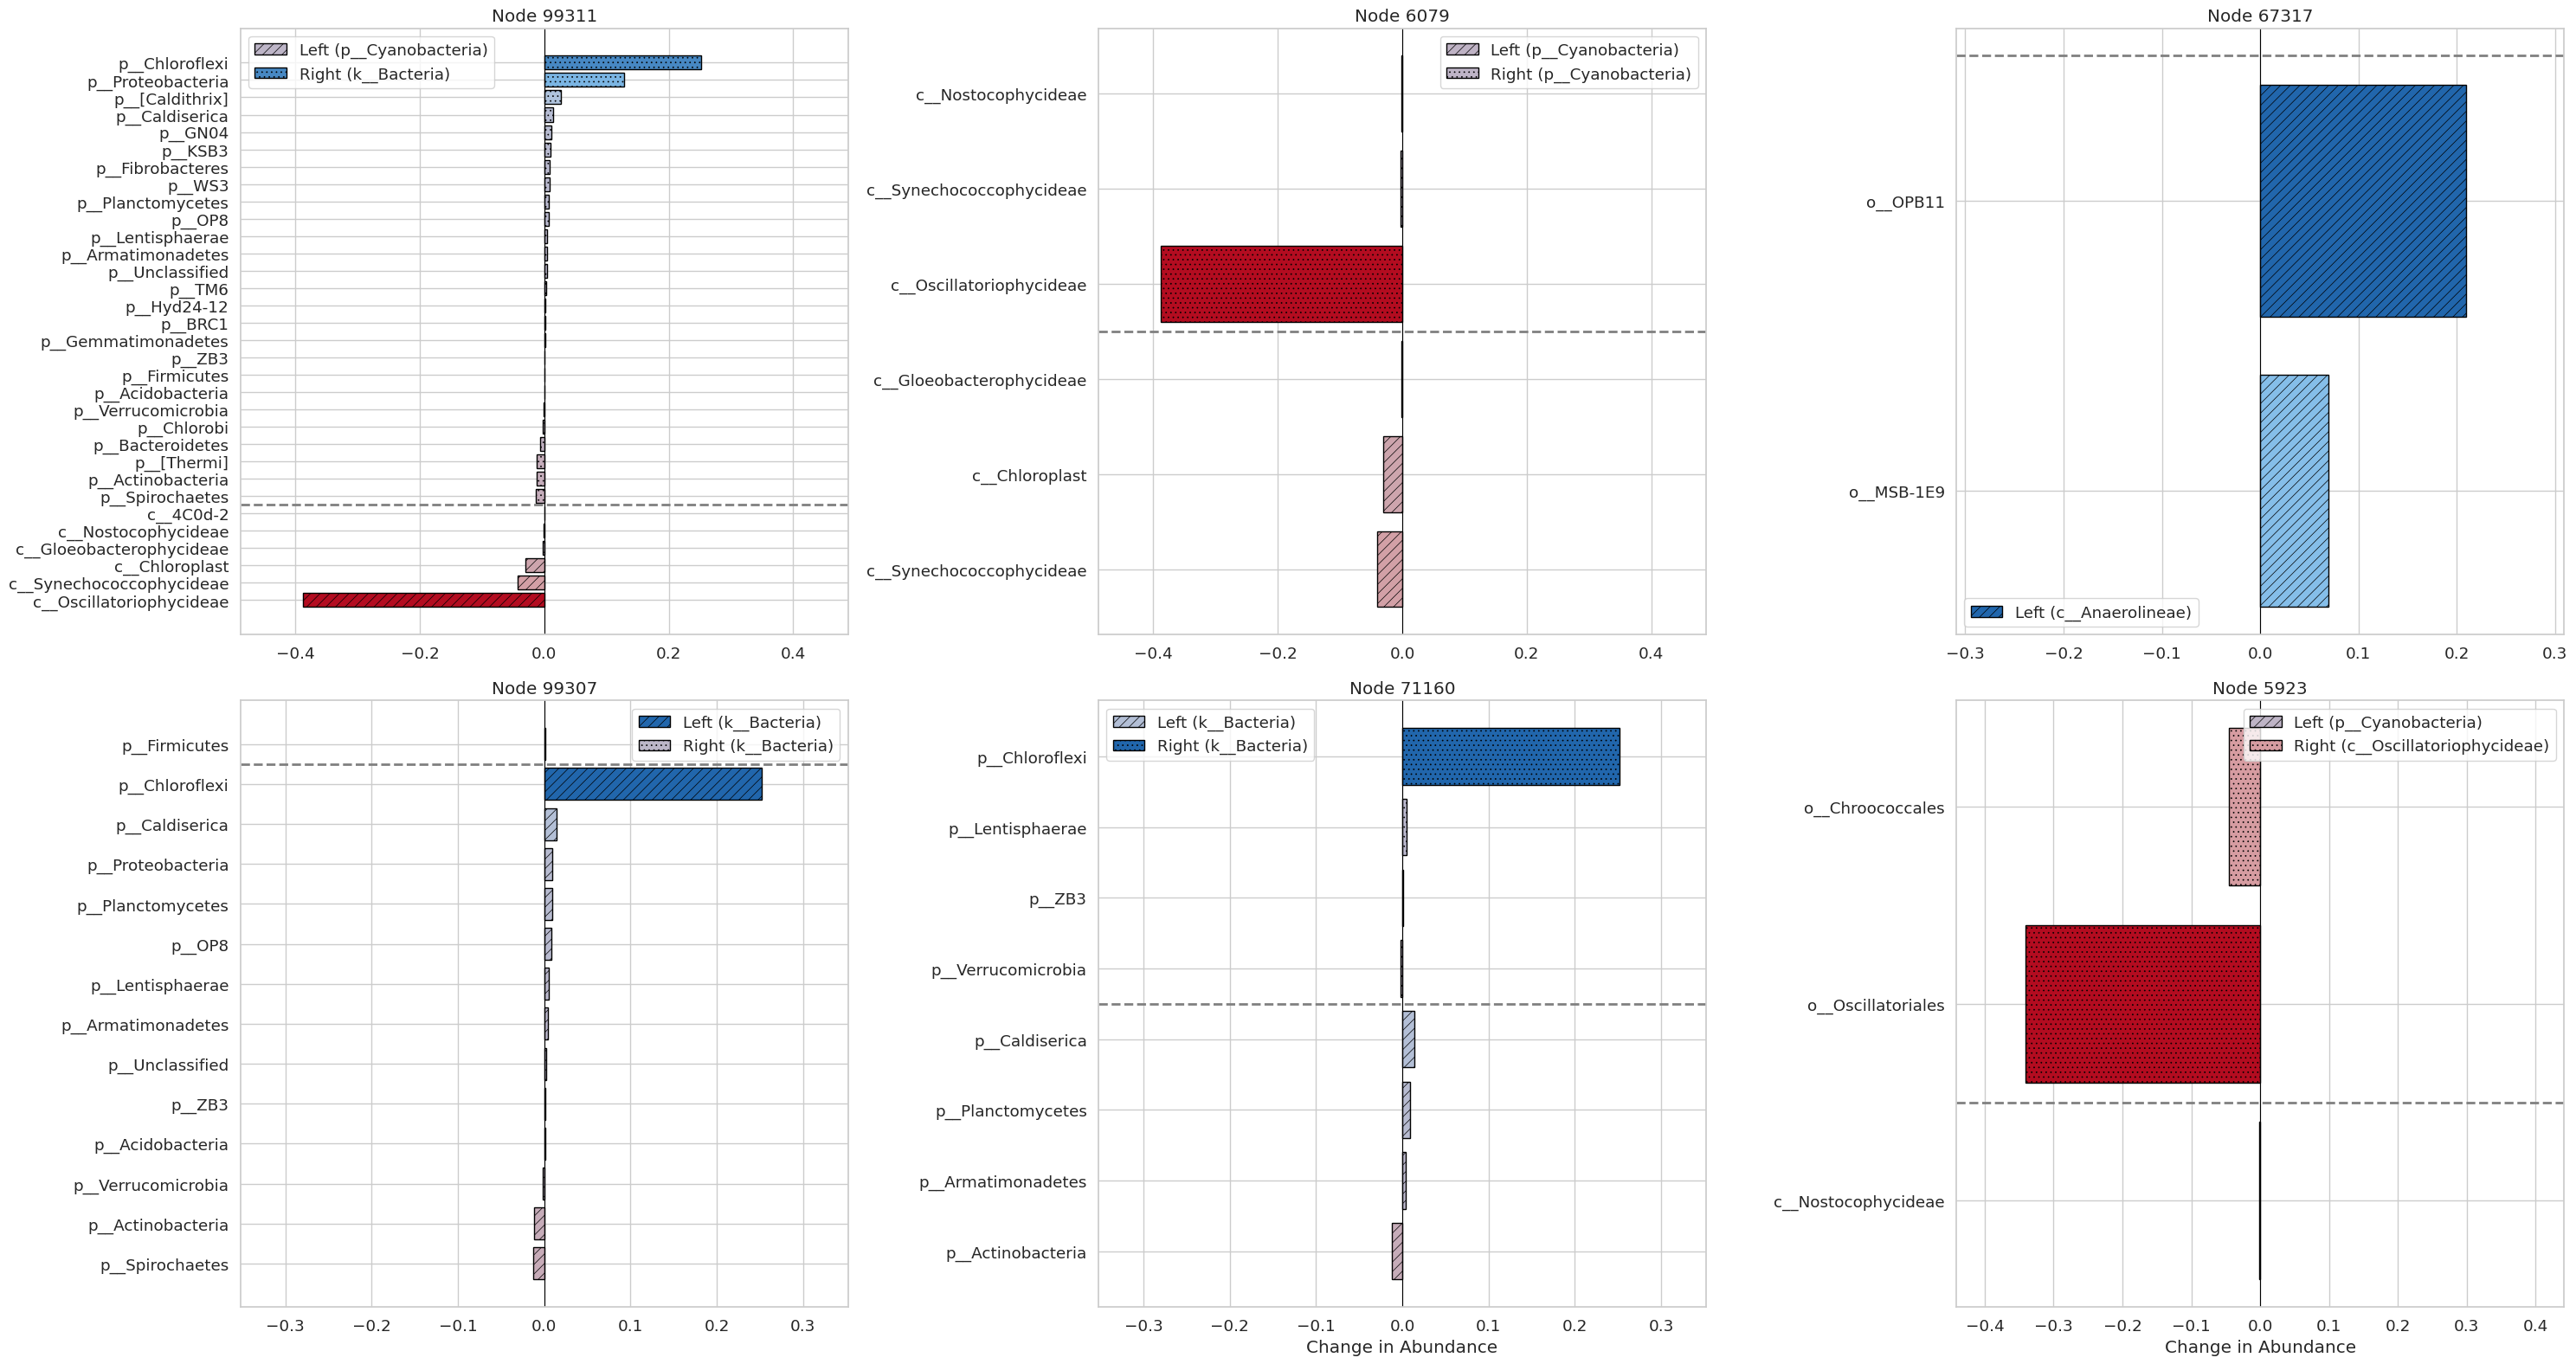

In [288]:
# Compute maximum number of taxa across all splits
max_n_taxa = 0
for split_data in gn_results[:6]:
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [
        t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values
    ]
    max_n_taxa = max(max_n_taxa, len(all_taxa))

# Determine bar heights based on max_n_taxa
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):
    split_data = gn_results[i]

    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values]
    n_taxa = len(all_taxa)
    # scale = n_taxa / max_n_taxa
    scale = 1.0

    plot_split(
        ax, split_data, linthresh=1e-1, min_frac=1e-10,
        full_height=full_height * scale
    )
    ax.set_title(f"Node {split_data['node']+1}")

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Abundance')
axes[-1].set_xlabel('Change in Abundance')

plt.tight_layout()
plt.show()

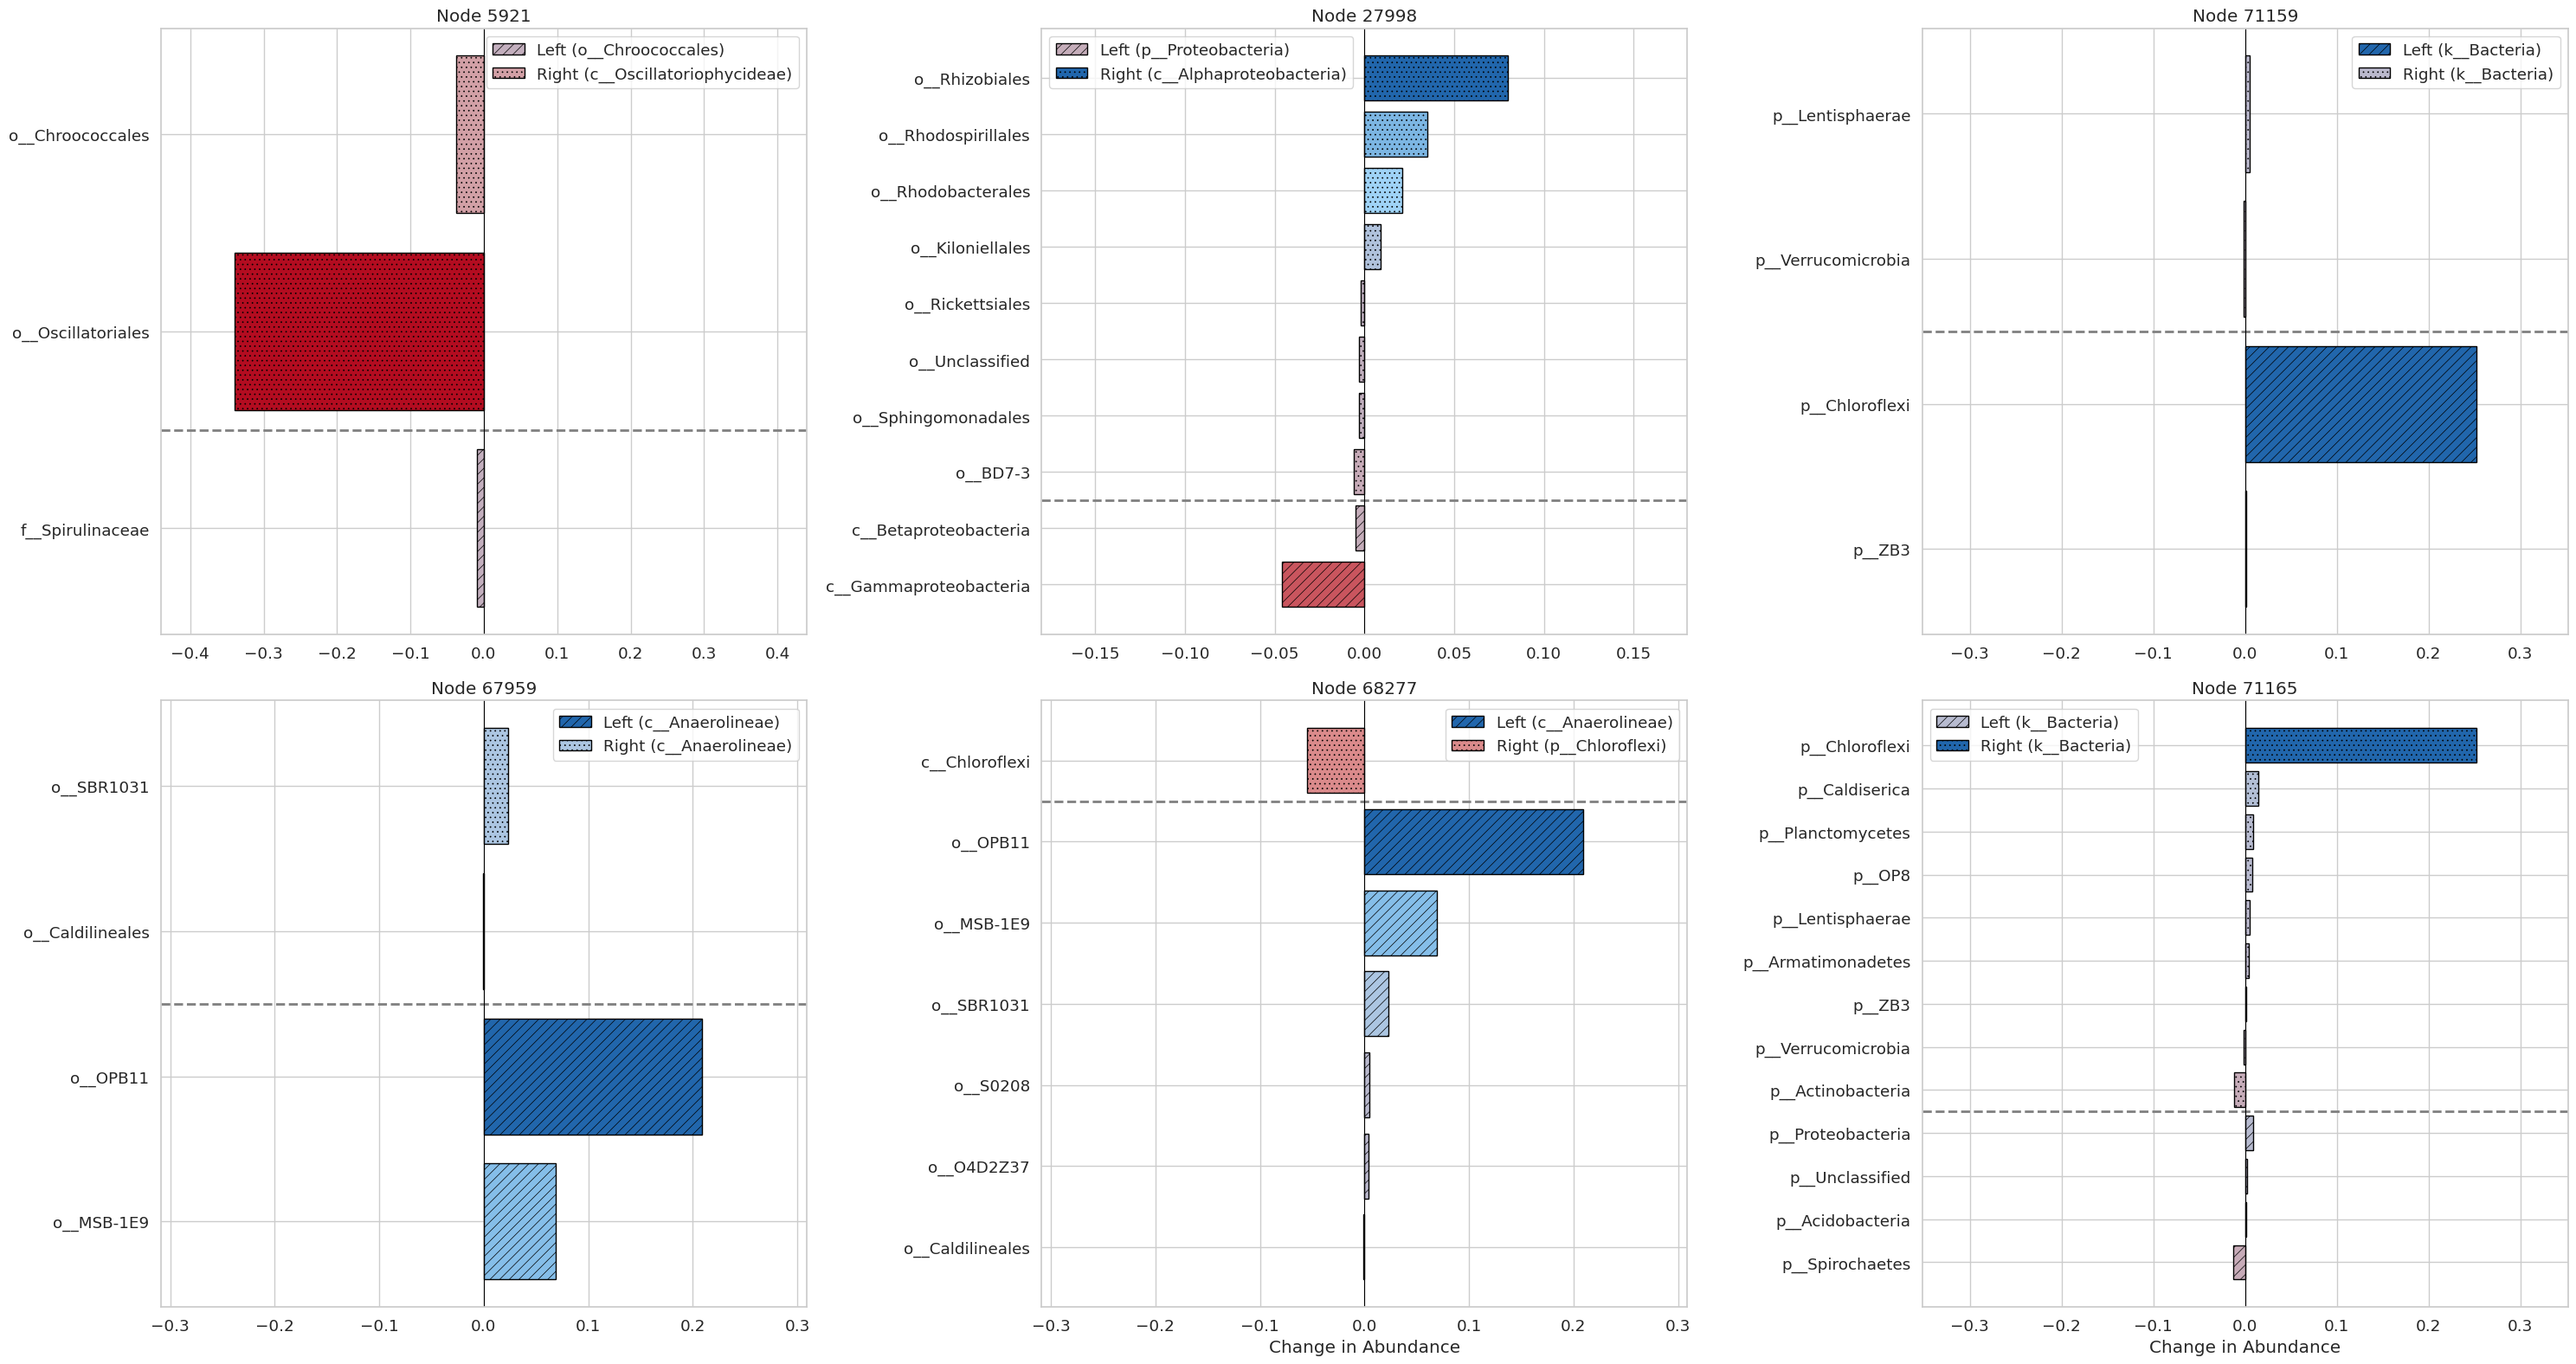

In [289]:
# Compute maximum number of taxa across all splits
max_n_taxa = 0
for split_data in gn_results[6:12]:
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [
        t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values
    ]
    max_n_taxa = max(max_n_taxa, len(all_taxa))

# Determine bar heights based on max_n_taxa
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):
    split_data = gn_results[i+6]

    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values]
    n_taxa = len(all_taxa)
    # scale = n_taxa / max_n_taxa
    scale = 1.0

    plot_split(
        ax, split_data, linthresh=1e-1, min_frac=1e-10,
        full_height=full_height * scale
    )
    ax.set_title(f"Node {split_data['node']+1}")

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Abundance')
axes[-1].set_xlabel('Change in Abundance')

plt.tight_layout()
plt.show()

## Part 3: Level of significance of Haar-like coordiantes of Human Body Sites dataset against 97% Greengenes tree

### Load 97% Greengenes tree

In [290]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

In [291]:
interior_nodes = tree.find_interior_nodes()
tax_filepath = os.path.join(GG_DATA, 'taxonomy/97_otu_taxonomy.txt')

In [292]:
edge_lengths = tree.get_edge_length()
min_edge_length = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {min_edge_length}")

for node in range(tree.n_nodes):
    tree.set_edge_length(node, max(min_edge_length, tree.get_edge_length(node)))

Enforced minimum edge lenght: 0.0001


### Load Body Sites dataset

In [293]:
bs_table_filepath = os.path.join(BS_DATA, '46767_otu_table.tsv')
bs_table_df = utils.load_seq_id_abundances_from_biom_tsv(bs_table_filepath)
bs_table_df.columns = bs_table_df.columns.str.replace(r'^449\.', '', regex=True).str.upper()

In [294]:
bs_table_df

,OTU ID,F21PLML,M22PINR,M32FOTR,M22PINL,F11FORR,F31KNEL,F31LABI,F31NSTR,F32HAIR,...,M31EWXL,F24EWAX,F22PINR,F23FOTL,M32APTL,M14EWAX,M31EWXR,M41EWXL,F22EWXL,F23EWAX
0,1124701,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,244331,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1050608,0.0,0.0,0.0,0.0,1.0,1.0,11.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,973124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,533625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8463,823633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8464,225846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8465,2063454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8466,998869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [295]:
bs_samp2site_filepath = os.path.join(BS_DATA, 'mapping.tsv')
bs_samp2site_df = utils.load_bs_samp2site_map(bs_samp2site_filepath)

In [296]:
bs_samp2site_df

Body habitat
EAC            [F11EWXL, F11EWXR, F12EWXL, F12EWXR, F13EWAX, ...
gut            [F11FCSP, F11FCSW, F12FCSP, F12FCSW, F13FCSW, ...
hair           [F11HAIR, F12HAIR, F21HAIR, F22HAIR, F31HAIR, ...
nostril        [F11NSTL, F11NSTR, F12NSTL, F12NSTR, F13NOST, ...
oral cavity    [F11MOUT, F11TONG, F12MOUT, F12TONG, F13TONG, ...
skin           [F11APTL, F11APTR, F11FORL, F11FORR, F11FOTL, ...
Name: SampleID, dtype: object

In [297]:
bs_sites_df = pd.DataFrame(index=bs_table_df.index)
bs_sites_df['OTU ID'] = bs_table_df['OTU ID']

for habitat, sample_list in bs_samp2site_df.items():
    bs_sites_df[habitat] = bs_table_df[bs_samp2site_df[habitat]].sum(axis=1)

In [298]:
# Convert counts to proportions
cols = bs_sites_df.columns[1:]
bs_sites_df[cols] = bs_sites_df[cols].div(bs_sites_df[cols].sum(axis=0), axis=1)

# Append leaf index column
leaf_idxs = seq_id2leaf_idx[bs_sites_df['OTU ID']].values
bs_sites_df.loc[:, 'Leaf Index'] = leaf_idxs
bs_sites_df.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [299]:
bs_sites_df

,OTU ID,EAC,gut,hair,nostril,oral cavity,skin,Leaf Index
0,4213913,0.000000,0.000000,0.0,0.000018,0.000011,0.000023,2471
1,4330849,0.000016,0.000000,0.0,0.000000,0.001747,0.000027,2472
2,4400869,0.000000,0.000000,0.0,0.000018,0.000276,0.000014,2474
3,4213909,0.000000,0.000000,0.0,0.000000,0.000000,0.000002,2475
4,200775,0.000000,0.000000,0.0,0.000000,0.000000,0.000002,2669
...,...,...,...,...,...,...,...,...
8463,4371300,0.000000,0.000030,0.0,0.000000,0.000000,0.000000,99302
8464,329313,0.000000,0.000134,0.0,0.000018,0.000000,0.000002,99307
8465,198626,0.000000,0.000074,0.0,0.000000,0.000000,0.000000,99311
8466,365125,0.000000,0.000030,0.0,0.000000,0.000000,0.000000,99316


### Compute Haar-like coordinates

In [300]:
Q, S = pcms.haar.sparsify(tree)

In [301]:
a_s = bs_sites_df['gut']
b_s = bs_sites_df['skin']

indices = bs_sites_df['Leaf Index'].values
n_leaves = tree.find_leaves().size

a_vals = a_s.values
a = np.zeros((n_leaves,))
a[indices] = a_vals

b_vals = b_s.values
b = np.zeros((n_leaves,))
b[indices] = b_vals

diff = a - b

In [302]:
hl_coords = Q.T @ diff
dh_comps = hl_coords**2 * S.diagonal()

In [303]:
S_coo = S.tocoo()
row, col, Svals = S_coo.row, S_coo.col, S_coo.data
hl_coords_i = hl_coords[row]
hl_coords_j = hl_coords[col]
contrib_data = Svals * hl_coords_i * hl_coords_j
M = csc_matrix((contrib_data, (row, col)), shape=S.shape)
M.eliminate_zeros()

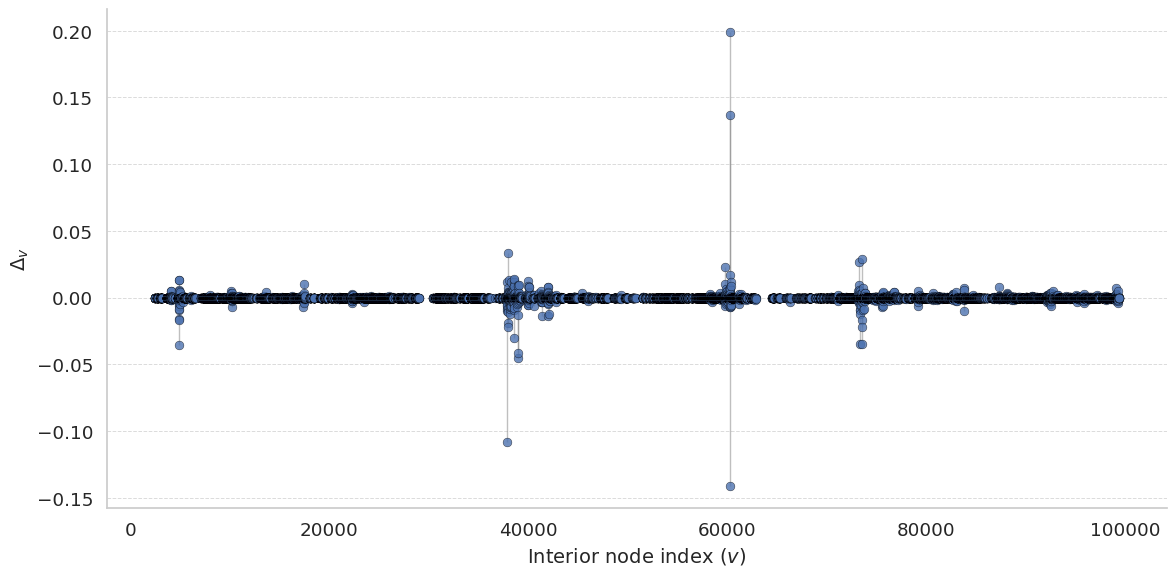

In [304]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(hl_coords)[0]
y = hl_coords[idx]
x = idx

# Scatter points colored by value with better aesthetics
ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Draw vertical lines behind scatter points
ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Improve axes labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

# Add a grid on y-axis only for clarity
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()

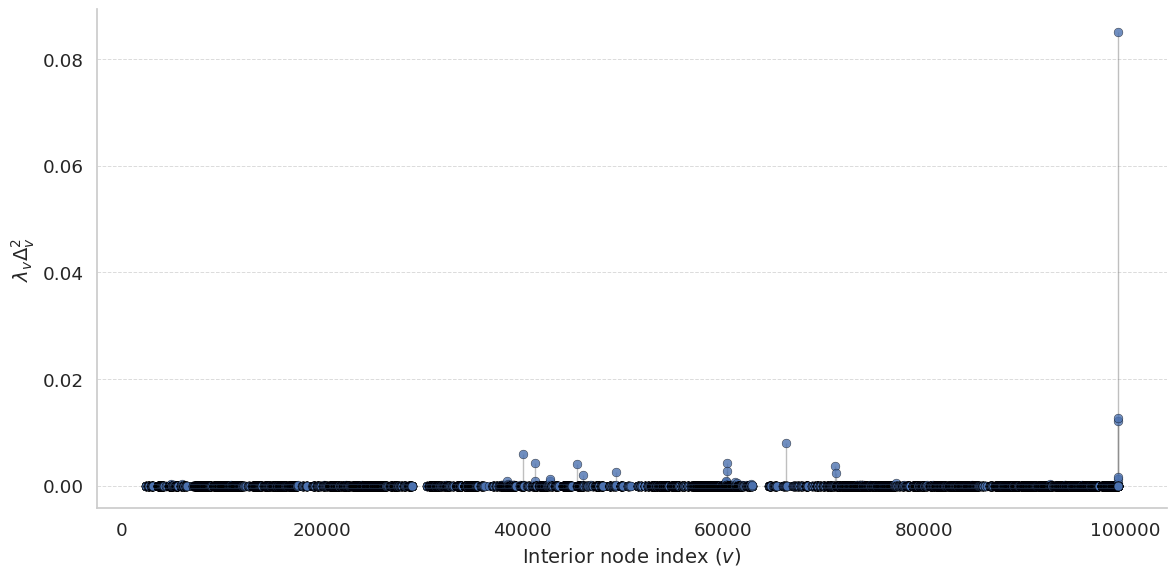

In [305]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(dh_comps)[0]
y = dh_comps[idx]
x = idx

# Scatter points with subtle edge for clarity
ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Vertical lines behind scatter points
ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

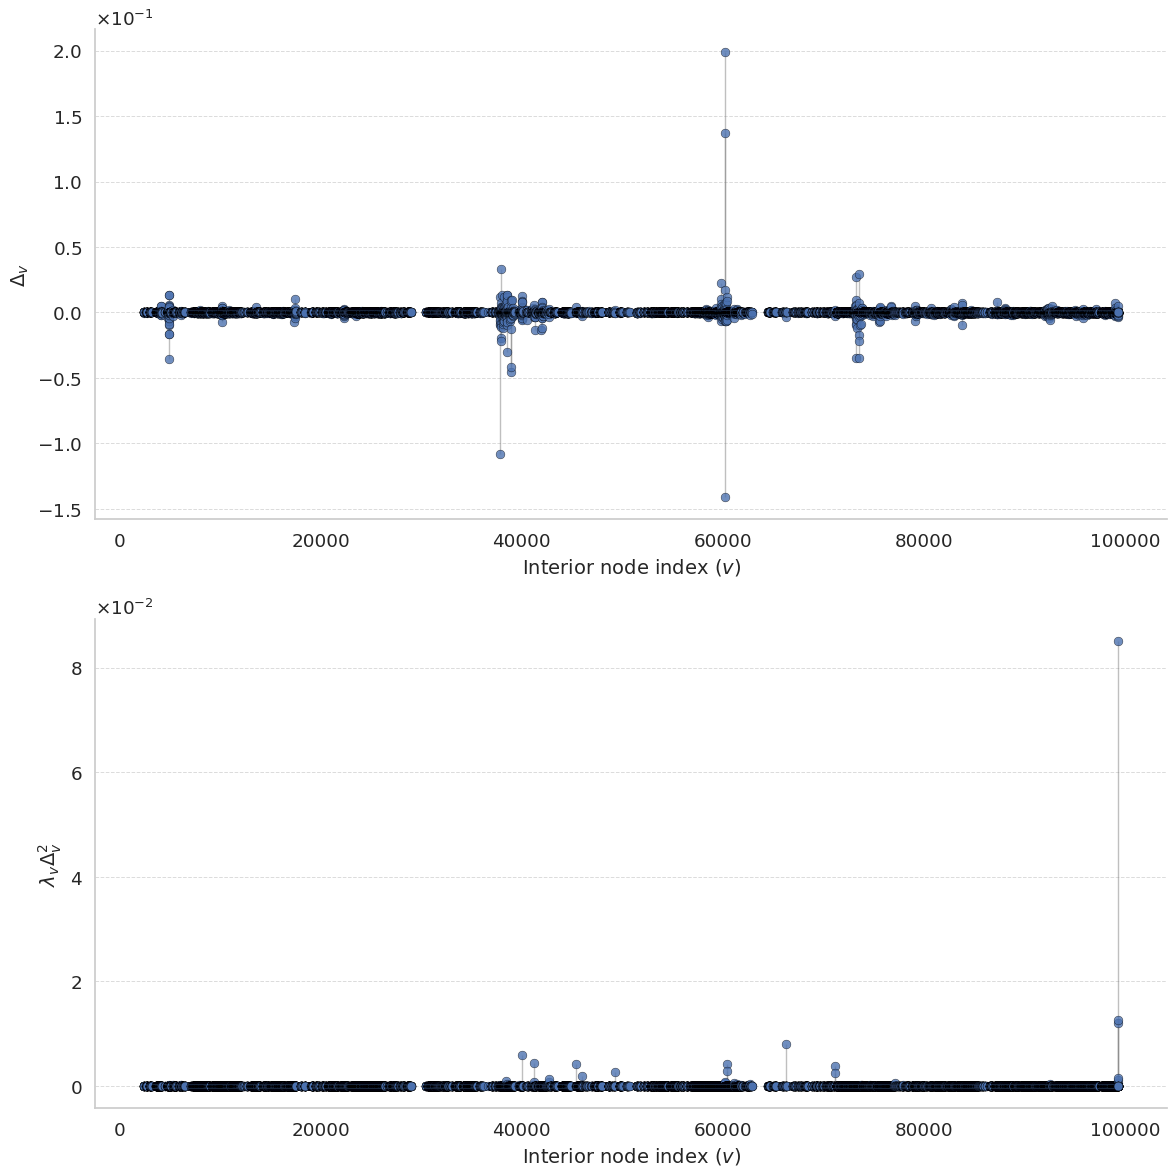

In [306]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharey=False)

# --- Plot 1: coords plot ---
idx = np.where(hl_coords)[0]
y = hl_coords[idx]
x = idx
# Scatter points colored by value with better aesthetics
ax1.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
# Draw vertical lines behind scatter points
ax1.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax1.set_xlabel('Interior node index ($v$)', fontsize=14)
ax1.set_ylabel(r'$\Delta_v$', fontsize=14)
ax1.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax1.xaxis.grid(False)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax1)

# --- Plot 2: dh_coords plot ---
idx = np.where(dh_comps)[0]
y = dh_comps[idx]
x = idx
# Scatter points with subtle edge for clarity
ax2.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
# Vertical lines behind scatter points
ax2.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax2.set_xlabel('Interior node index ($v$)', fontsize=14)
ax2.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax2.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax2.xaxis.grid(False)
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

### Taxonomic classification of splits

In [307]:
N = 12
idxs = np.argsort(dh_comps)[::-1][:N]
with open("../data/bs_tax_table_output.txt", "w") as f:
    bs_results = format_tax_table(idxs, abunds=diff, max_ranks=1, file=f)

In [308]:
rename_unclassified(bs_results)

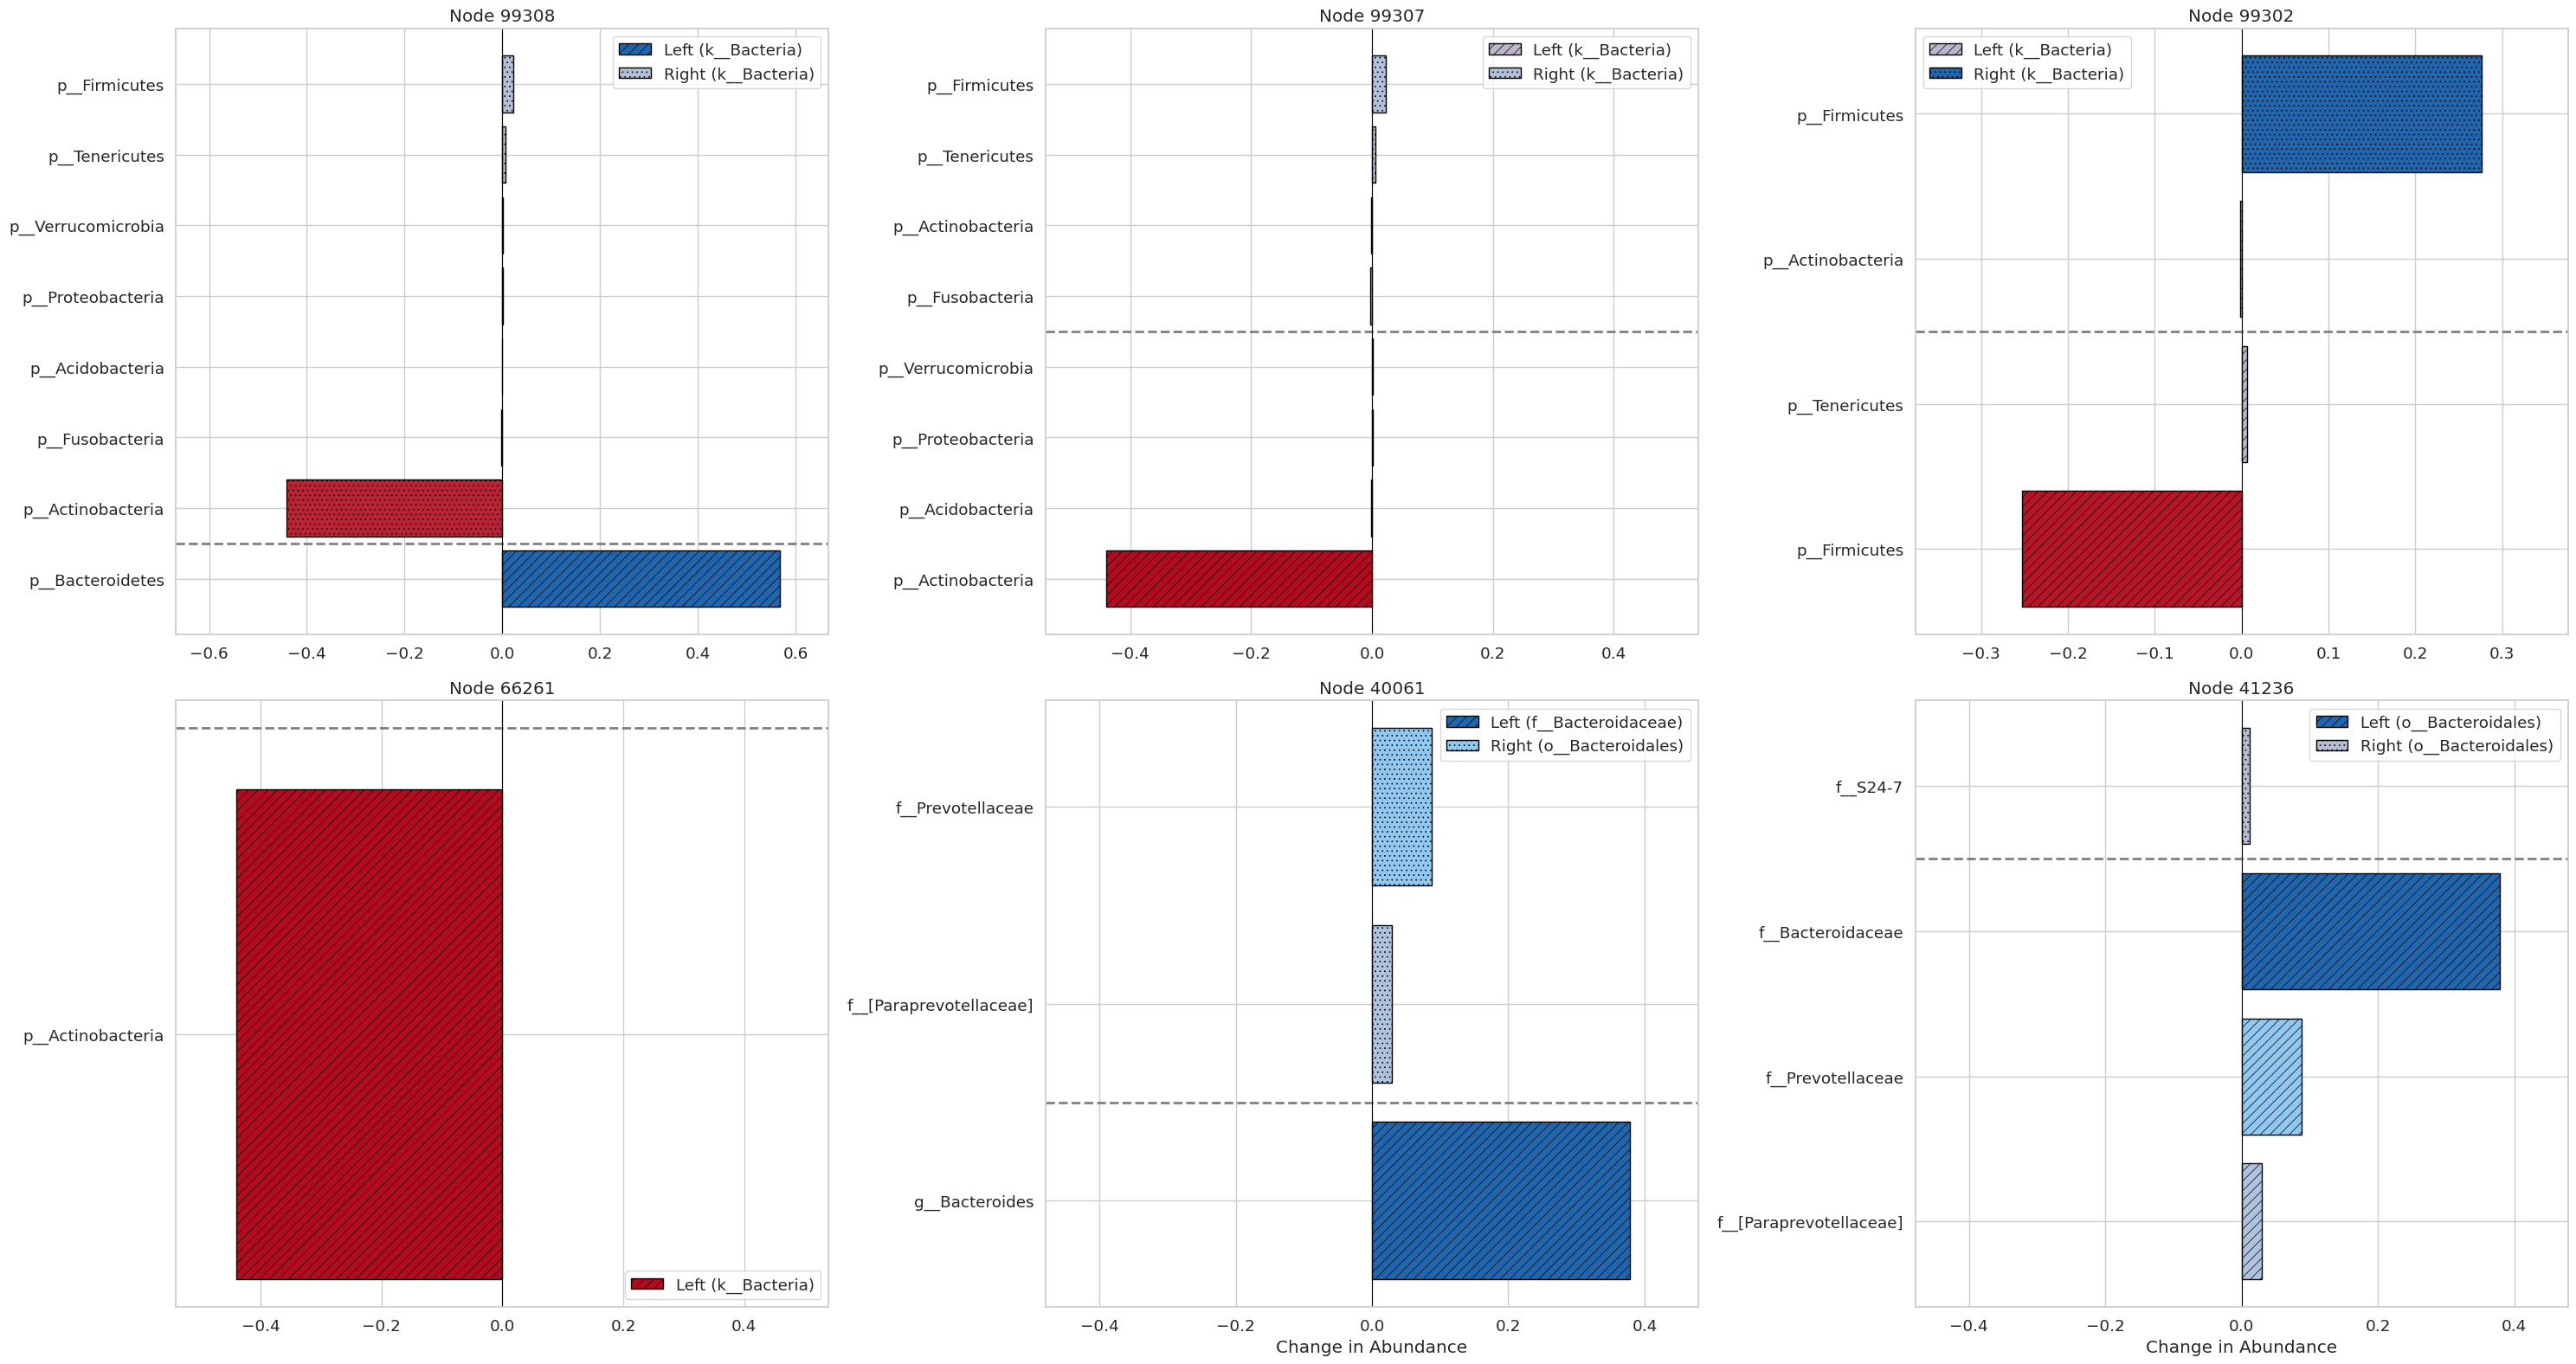

In [309]:
# Compute maximum number of taxa across all splits
max_n_taxa = 0
for split_data in bs_results[:6]:
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [
        t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values
    ]
    max_n_taxa = max(max_n_taxa, len(all_taxa))

# Determine bar heights based on max_n_taxa
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):
    split_data = bs_results[i]

    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values]
    n_taxa = len(all_taxa)
    # scale = n_taxa / max_n_taxa
    scale = 1.0

    plot_split(
        ax, split_data, linthresh=1e-1, min_frac=1e-10,
        full_height=full_height * scale
    )
    ax.set_title(f"Node {split_data['node']+1}")

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Abundance')
axes[-1].set_xlabel('Change in Abundance')

plt.tight_layout()
plt.show()

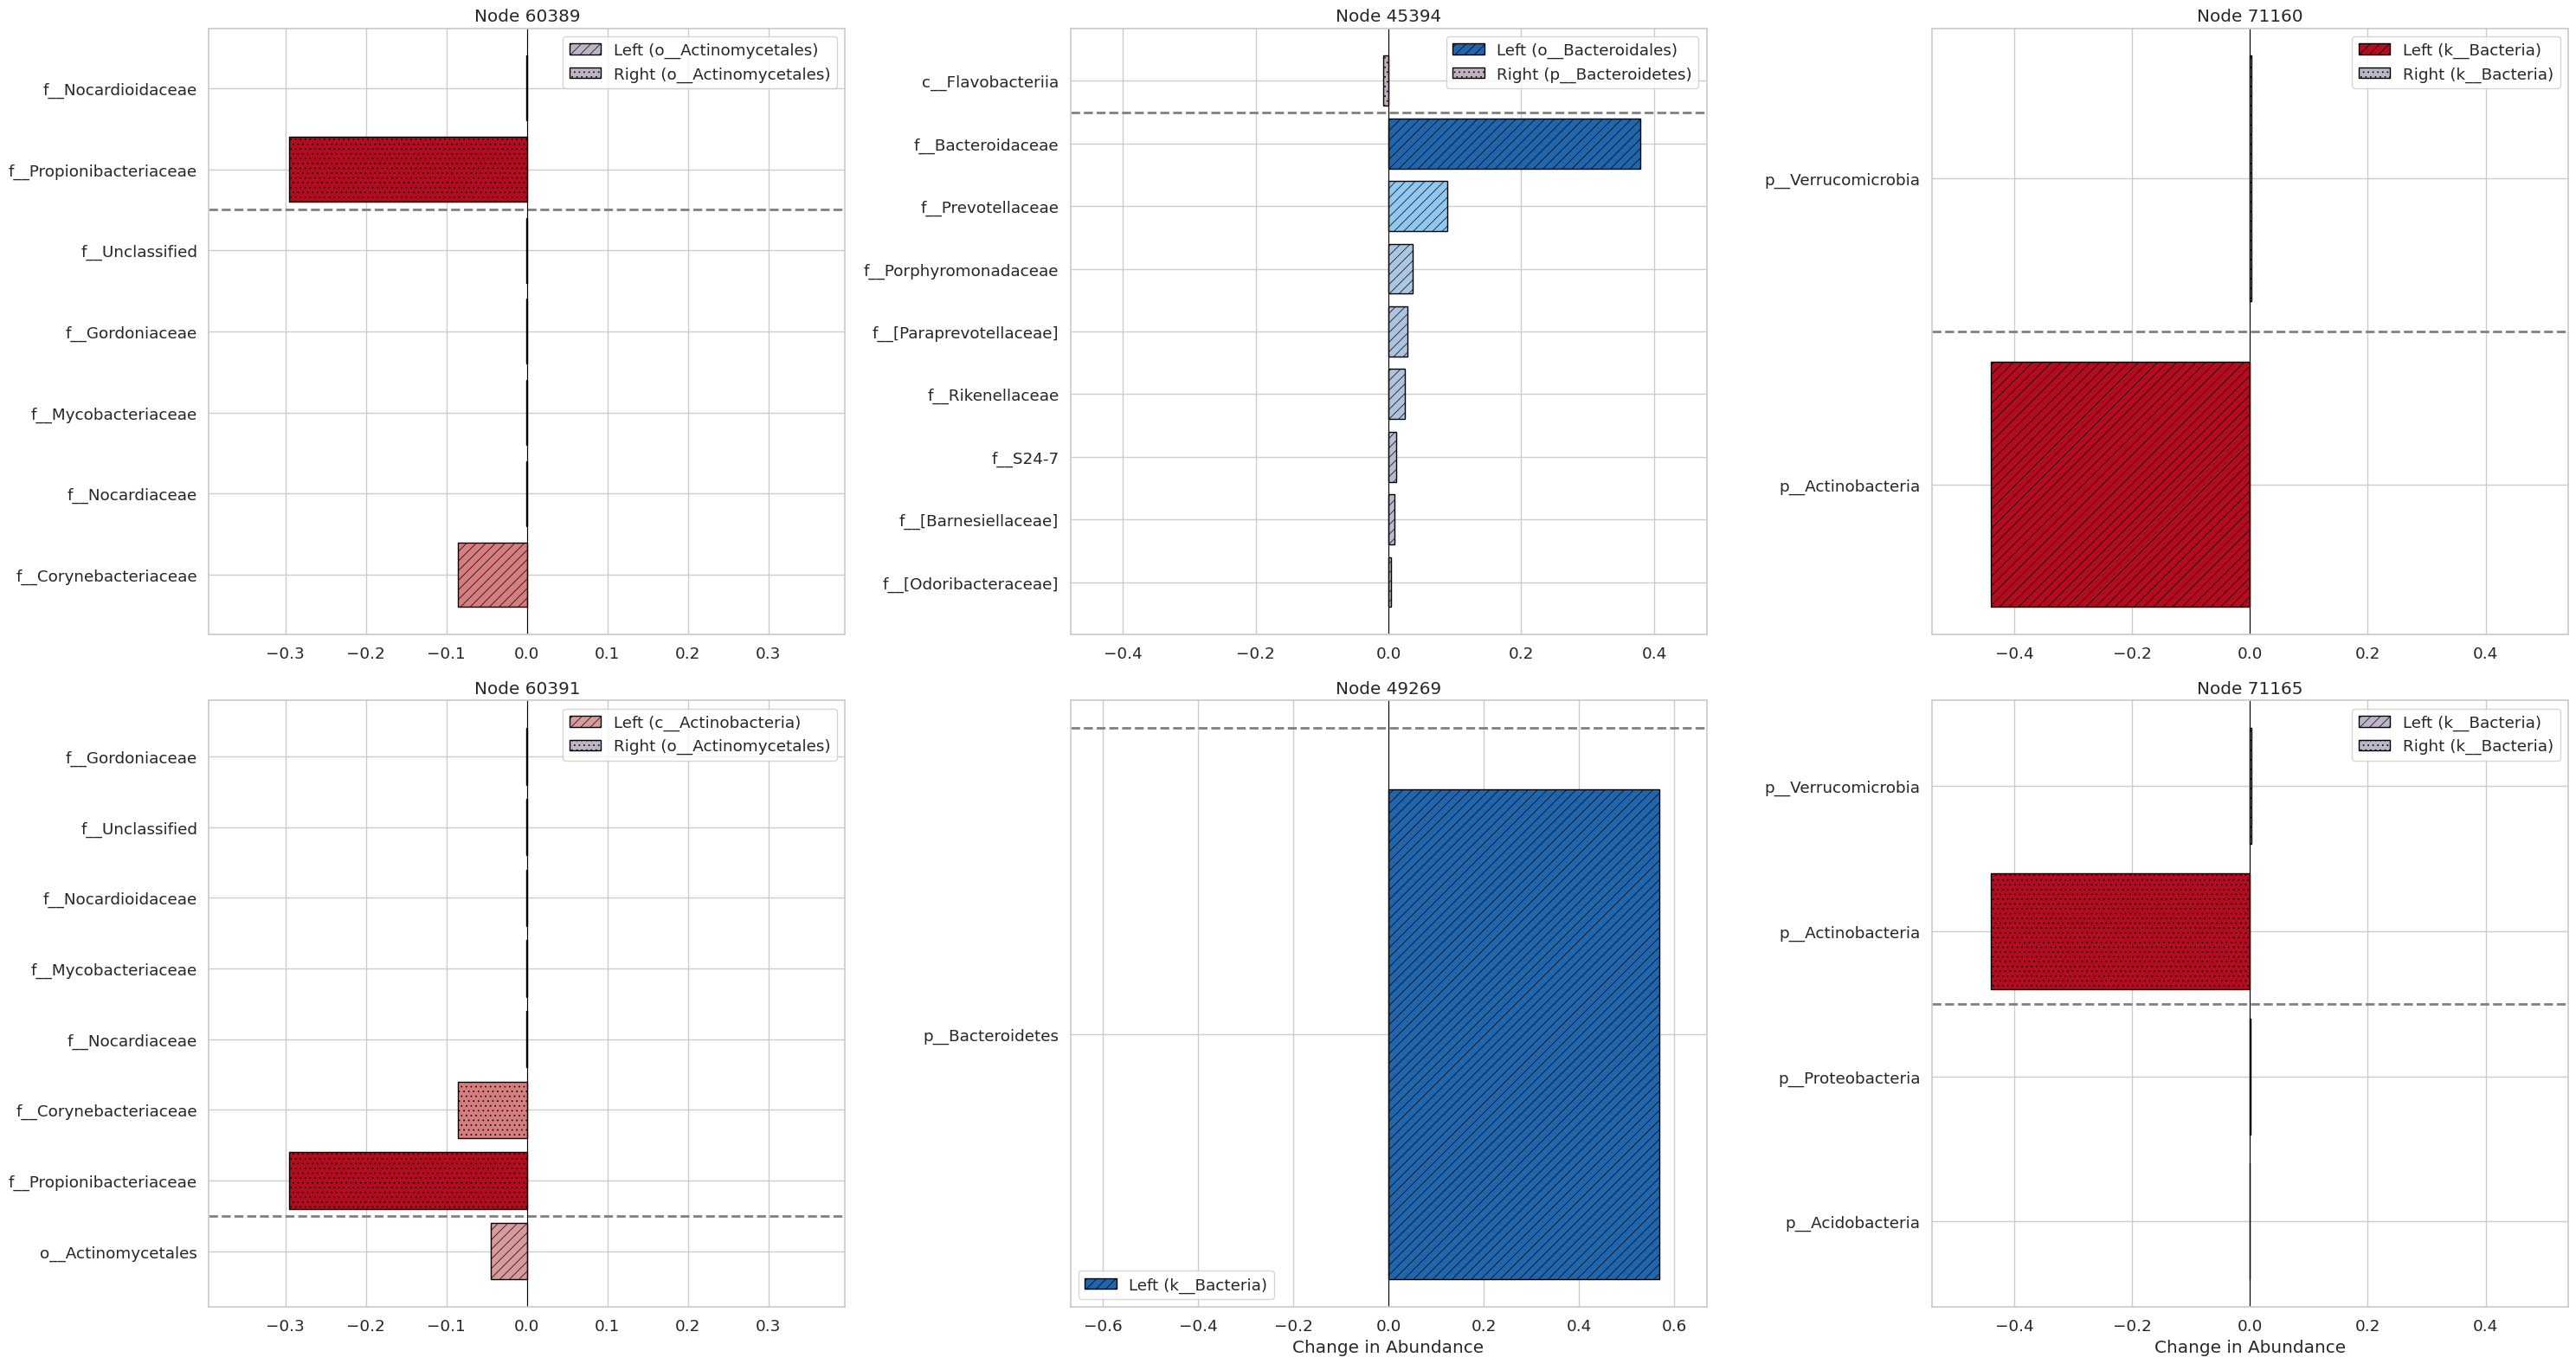

In [311]:
# Compute maximum number of taxa across all splits
max_n_taxa = 0
for split_data in bs_results[6:12]:
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [
        t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values
    ]
    max_n_taxa = max(max_n_taxa, len(all_taxa))

# Determine bar heights based on max_n_taxa
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):
    split_data = bs_results[i+6]

    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])
    all_taxa = list(left_df["taxon"].str.strip()) + [t.strip() for t in right_df["taxon"] if t.strip() not in left_df["taxon"].str.strip().values]
    n_taxa = len(all_taxa)
    # scale = n_taxa / max_n_taxa
    scale = 1.0

    plot_split(
        ax, split_data, linthresh=1e-1, min_frac=1e-10,
        full_height=full_height * scale
    )
    ax.set_title(f"Node {split_data['node']+1}")

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Abundance')
axes[-1].set_xlabel('Change in Abundance')

plt.tight_layout()
plt.show()